训练自编码器

欧卡姆提剃刀做消融实验

卷积+MLP
---

训练结果：

训练误差最小：0.0022515379823744297



In [1]:
# 直接训练
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
import os

from torch.utils.tensorboard import SummaryWriter

from model.PIAE_models import T7PIAE2
import numpy as np

# 检查是否有可用的GPU
if torch.cuda.is_available():
    print('显卡参与训练')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练开始前启用 PyTorch 的异常检测
torch.autograd.set_detect_anomaly(True)

显卡参与训练


In [2]:
# 加载数据
# 1. 加载预处理后的数据
##

def load_preprocessed_data(input_file):
    with open(input_file, 'rb') as f:
        data = pickle.load(f)
    return data


input_file = '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/data/Task1_data'  # 替换为你保存的.pkl文件路径

tarin_data = load_preprocessed_data(os.path.join(input_file,'train_data.kpl'))
val_data = load_preprocessed_data(os.path.join(input_file,'val_data.kpl'))
dataset = TensorDataset(tarin_data[0],tarin_data[1],tarin_data[2],tarin_data[3])

dataloader = DataLoader(dataset, batch_size=600, shuffle=True)

val_feat = val_data[0].to(device)
val_edagepoint = val_data[1].to(device)
val_endstate = val_data[2].to(device)
val_label = val_data[3].to(device)

In [3]:

# 3. 定义模型、损失函数和优化器
#模型
model = T7PIAE2(torch.tensor(10),torch.tensor(0.25))

# 损失函数
criterion = nn.MSELoss()

# 优化器
optimizer = optim.Adam(model.parameters(), lr=1e-3) 

model.to(device)


T7PIAE2(
  (encoder): Sequential(
    (0): Conv1d(2, 10, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(10, 20, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=380, out_features=800, bias=True)
    (6): ReLU()
    (7): Linear(in_features=800, out_features=400, bias=True)
    (8): ReLU()
  )
  (encoder_ax): Sequential(
    (0): Linear(in_features=200, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=18, bias=True)
    (3): Tanh()
  )
  (encoder_delta): Sequential(
    (0): Linear(in_features=200, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=18, bias=True)
    (3): Tanh()
  )
)

In [4]:
%clear

# 创建一个SummaryWriter对象，指定日志保存的路径
writer = SummaryWriter('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/logs/log2')


# 4. 训练模型Autoencoder
epochs = 600

best_loss = float('inf')

for epoch in range(epochs):
    
    model.train()  # 确保模型处于训练模式
    for batch_idx, (feat,edagepoint,endstate,label) in enumerate(dataloader):  
        
        label = label.to(device)  # 将输入数据移动到同一设备
        feat = feat.to(device)
        edagepoint = edagepoint.to(device)
        endstate = endstate.to(device)

        optimizer.zero_grad()
        outputs,actions = model(feat,edagepoint,endstate)

        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()


    model.eval()
    with torch.no_grad():
        val_output,val_action = model(val_feat,val_edagepoint,val_endstate)
        val_loss = criterion(val_output,val_label)
    
    # torch.save(model.state_dict(), f'/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test6_piae_good/model/Task4_trained_model/model_{epoch:03}.pth')
    if val_loss.item() < best_loss :
        # 保存模型
        torch.save(model.state_dict(), '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/model/trained_models/Task2_model_best.pth')
        best_loss = val_loss.item()


    print(f'\rEpoch {epoch+1}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()} ')
    # print()
    # 使用SummaryWriter记录数据
    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)


# 关闭SummaryWriter
writer.close()
   


Epoch 1, Train Loss: 0.05025923624634743, Val Loss: 0.04139188677072525 
Epoch 2, Train Loss: 0.02583981677889824, Val Loss: 0.027591699734330177 
Epoch 3, Train Loss: 0.02312813512980938, Val Loss: 0.030837465077638626 
Epoch 4, Train Loss: 0.03140706568956375, Val Loss: 0.03788239508867264 
Epoch 5, Train Loss: 0.009378569200634956, Val Loss: 0.012572805397212505 
Epoch 6, Train Loss: 0.006818043999373913, Val Loss: 0.009093832224607468 
Epoch 7, Train Loss: 0.006358275189995766, Val Loss: 0.008386853151023388 
Epoch 8, Train Loss: 0.00475933775305748, Val Loss: 0.008278565481305122 
Epoch 9, Train Loss: 0.015597720630466938, Val Loss: 0.010557393543422222 
Epoch 10, Train Loss: 0.006330267060548067, Val Loss: 0.007167224772274494 
Epoch 11, Train Loss: 0.006201045121997595, Val Loss: 0.008685970678925514 
Epoch 12, Train Loss: 0.004772345069795847, Val Loss: 0.006881245411932468 
Epoch 13, Train Loss: 0.0024616881273686886, Val Loss: 0.005992397665977478 
Epoch 14, Train Loss: 0.005

In [5]:


model.load_state_dict(torch.load('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/model/trained_models/Task2_model_best.pth', weights_only=True))

with torch.no_grad():
    val_output,val_action = model(val_feat,val_edagepoint,val_endstate)
    val_loss = criterion(val_output,val_label)
    print('\r重构误差：',val_loss.item())



重构误差： 0.0022515379823744297


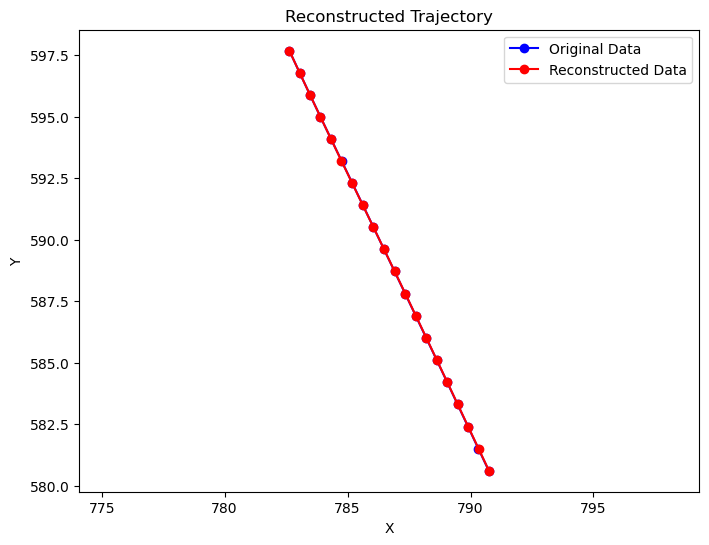

In [6]:
plt.figure(figsize=(8, 6))
# 绘制原始轨迹

# num = 845
num = np.random.randint(0,30000)
# num = 0
plt.plot(val_label.cpu().numpy()[num, :,0], val_label.cpu().numpy()[num, :,1], '-o',c='blue', label='Original Data')
plt.plot(val_output.cpu().numpy()[num, :,0], val_output.cpu().numpy()[num, :,1], '-o', c='red', label='Reconstructed Data')
plt.title('Reconstructed Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.show()